In [1]:
%reload_ext autoreload
%autoreload 2

import os
from pathlib import Path
import multiprocessing

import numpy as np
import jax
import numpyro

from hbmep.config import Config
from hbmep.model import Model
from hbmep.model.utils import Site as site

from hbmep_paper.model import HierarchicalBayesian
from hbmep_paper.utils import simulate, run_experiment

PLATFORM = "cpu"
jax.config.update("jax_platforms", PLATFORM)
numpyro.set_platform(PLATFORM)

cpu_count = multiprocessing.cpu_count() - 2
numpyro.set_host_device_count(cpu_count)
numpyro.enable_x64()
numpyro.enable_validation()



In [2]:
root_path = Path(os.getcwd()).parent.parent.parent.absolute()
toml_path = os.path.join(root_path, "configs/experiments.toml")

config = Config(toml_path=toml_path)
config.BUILD_DIR = "/home/vishu/repos/hbmep-paper/reports/reparam/"


2023-08-02 14:27:52,566 - hbmep.config - INFO - Verifying configuration ...
2023-08-02 14:27:52,566 - hbmep.config - INFO - Success!


In [3]:
import pandas as pd

from numpyro.infer import MCMC, NUTS, Predictive


import jax.numpy as jnp
import numpyro.distributions as dist

from hbmep.model import Baseline
from hbmep.utils.constants import RECTIFIED_LOGISTIC
from hbmep.utils import timing

from numpyro.infer.reparam import TransformReparam
from numpyro.distributions.transforms import AffineTransform, AbsTransform


class RectifiedLogistic(Baseline):
    LINK = RECTIFIED_LOGISTIC

    def __init__(self, config: Config):
        super(RectifiedLogistic, self).__init__(config=config)

    def _model(self, subject, features, intensity, response_obs=None):
        intensity = intensity.reshape(-1, 1)
        intensity = np.tile(intensity, (1, self.n_response))

        feature0 = features[0].reshape(-1,)

        n_data = intensity.shape[0]
        n_subject = np.unique(subject).shape[0]
        n_feature0 = np.unique(feature0).shape[0]

        with numpyro.plate(site.n_response, self.n_response, dim=-1):
            with numpyro.plate(site.n_subject, n_subject, dim=-2):
                """ Hyper-priors """
                # _mu_a = numpyro.deterministic("_mu_a", 0)
                # _sigma_a = numpyro.deterministic("_sigma_a", 1)
                mu_a = numpyro.sample(
                    site.mu_a,
                    dist.TruncatedNormal(150, 50, low=0)
                )
                sigma_a = numpyro.sample(site.sigma_a, dist.HalfNormal(50))

                sigma_b = numpyro.sample(site.sigma_b, dist.HalfNormal(0.1))

                sigma_L = numpyro.sample(site.sigma_L, dist.HalfNormal(0.05))
                sigma_H = numpyro.sample(site.sigma_H, dist.HalfNormal(5))
                sigma_v = numpyro.sample(site.sigma_v, dist.HalfNormal(10))

                with numpyro.plate("n_feature0", n_feature0, dim=-3):
                    """ Priors """
                    # a = numpyro.sample(
                    #     site.a,
                    #     dist.TruncatedNormal(mu_a, sigma_a, low=0)
                    # )
                    # b = numpyro.sample(site.b, dist.HalfNormal(sigma_b))

                    # L = numpyro.sample(site.L, dist.HalfNormal(sigma_L))
                    # H = numpyro.sample(site.H, dist.HalfNormal(sigma_H))
                    # v = numpyro.sample(site.v, dist.HalfNormal(sigma_v))

                    reparam_config = {
                        var: TransformReparam() for var in [site.a, site.b, site.L, site.H, site.v]
                    }

                    with numpyro.handlers.reparam(config=reparam_config):
                        a = numpyro.sample(
                            site.a,
                            dist.TransformedDistribution(
                                dist.Normal(0, 1),
                                [AffineTransform(mu_a, sigma_a), AbsTransform()]
                            )
                        )
                        b = numpyro.sample(
                            site.b,
                            dist.TransformedDistribution(
                                dist.Normal(0, 1),
                                [AffineTransform(0, sigma_b), AbsTransform()]
                            )
                        )

                        L = numpyro.sample(
                            site.L,
                            dist.TransformedDistribution(
                                dist.Normal(0, 1),
                                [AffineTransform(0, sigma_L), AbsTransform()]
                            )
                        )
                        H = numpyro.sample(
                            site.H,
                            dist.TransformedDistribution(
                                dist.Normal(0, 1),
                                [AffineTransform(0, sigma_H), AbsTransform()]
                            )
                        )
                        v = numpyro.sample(
                            site.v,
                            dist.TransformedDistribution(
                                dist.Normal(0, 1),
                                [AffineTransform(0, sigma_v), AbsTransform()]
                            )
                        )

                    g_1 = numpyro.sample(site.g_1, dist.Exponential(0.01))
                    g_2 = numpyro.sample(site.g_2, dist.Exponential(0.01))

        """ Model """
        mu = numpyro.deterministic(
            site.mu,
            L[feature0, subject]
            + jnp.maximum(
                0,
                -1
                + (H[feature0, subject] + 1)
                / jnp.power(
                    1
                    + (jnp.power(1 + H[feature0, subject], v[feature0, subject]) - 1)
                    * jnp.exp(-b[feature0, subject] * (intensity - a[feature0, subject])),
                    1 / v[feature0, subject]
                )
            )
        )
        beta = numpyro.deterministic(
            site.beta,
            g_1[feature0, subject] + g_2[feature0, subject] * (1 / mu)
        )

        """ Observation """
        with numpyro.plate(site.data, n_data):
            return numpyro.sample(
                site.obs,
                dist.Gamma(concentration=mu * beta, rate=beta).to_event(1),
                obs=response_obs
            )

    # @timing
    # def run_inference(self, df: pd.DataFrame) -> tuple[numpyro.infer.mcmc.MCMC, dict]:
    #     """ Set up NUTS sampler """
    #     nuts_kernel = NUTS(self._model, init_strategy=numpyro.infer.init_to_sample, max_tree_depth=20)
    #     mcmc = MCMC(nuts_kernel, **self.mcmc_params)
    #     rng_key = jax.random.PRNGKey(self.random_state)

    #     """ MCMC inference """
    #     mcmc.run(rng_key, *self._collect_regressors(df=df), *self._collect_response(df=df))
    #     posterior_samples = mcmc.get_samples()
    #     return mcmc, posterior_samples


simulator = RectifiedLogistic(config=config)

simulation_params = {
    "n_subject": 5,
    "n_feature0": 15,
    "n_repeats": 100
}
df, posterior_samples_true = simulate(model=simulator, **simulation_params)
obs = np.array(posterior_samples_true[site.obs])

# # ind = df[["participant", "compound_position"]].apply(tuple, axis=1).isin([(0, 0)])
# ind = df.participant.isin([2])
# df = df[ind].copy()
# df.reset_index(drop=True, inplace=True)
# obs = obs[:, ind, :]

model = RectifiedLogistic(config=config)
df[model.response] = obs[0, ...]

df, encoder_dict = model.load(df=df)



2023-08-02 14:27:52,638 - hbmep.model.baseline - INFO - Initialized model with rectified_logistic link
2023-08-02 14:27:52,639 - hbmep_paper.utils.utils - INFO - Simulating data ...


2023-08-02 14:27:55,210 - hbmep.utils.utils - INFO - func:predict took: 2.57 sec
2023-08-02 14:27:55,211 - hbmep.utils.utils - INFO - func:simulate took: 2.57 sec
2023-08-02 14:27:55,212 - hbmep.model.baseline - INFO - Initialized model with rectified_logistic link
2023-08-02 14:27:55,213 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/reparam/
2023-08-02 14:27:55,213 - hbmep.dataset.core - INFO - Copied config to /home/vishu/repos/hbmep-paper/reports/reparam/
2023-08-02 14:27:55,214 - hbmep.dataset.core - INFO - Processing data ...
2023-08-02 14:27:55,215 - hbmep.utils.utils - INFO - func:load took: 0.00 sec


In [4]:
model.plot(df=df, encoder_dict=encoder_dict)

2023-08-02 14:28:00,666 - hbmep.dataset.core - INFO - Plotting dataset ...
2023-08-02 14:28:14,264 - hbmep.dataset.core - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/reparam/dataset.pdf
2023-08-02 14:28:14,264 - hbmep.utils.utils - INFO - func:plot took: 13.60 sec


In [5]:
mcmc, posterior_samples = model.run_inference(df=df)

2023-08-02 14:29:31,275 - hbmep.model.baseline - INFO - Running inference with rectified_logistic ...


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [ ]:
mcmc.print_summary(prob=.95)

NameError: name 'mcmc' is not defined

In [ ]:
model.render_recruitment_curves(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-02 13:55:02,118 - hbmep.model.baseline - INFO - Generating predictions ...
2023-08-02 13:55:07,365 - hbmep.utils.utils - INFO - func:predict took: 5.24 sec
2023-08-02 13:55:07,387 - hbmep.model.baseline - INFO - Rendering recruitment curves ...
2023-08-02 13:55:09,222 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/reparam/recruitment_curves.pdf
2023-08-02 13:55:09,223 - hbmep.utils.utils - INFO - func:render_recruitment_curves took: 7.10 sec


In [ ]:
model.render_predictive_check(df=df, encoder_dict=encoder_dict, posterior_samples=posterior_samples)


2023-08-02 13:55:09,331 - hbmep.model.baseline - INFO - Generating predictions ...
2023-08-02 13:55:14,501 - hbmep.utils.utils - INFO - func:predict took: 5.17 sec
2023-08-02 13:55:14,538 - hbmep.model.baseline - INFO - Rendering Posterior Predictive Check ...
2023-08-02 13:55:17,750 - hbmep.model.baseline - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/reparam/posterior_predictive_check.pdf
2023-08-02 13:55:17,751 - hbmep.utils.utils - INFO - func:render_predictive_check took: 8.42 sec


In [8]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

posterior_samples_2 = mcmc.get_samples(group_by_chain=True)
a = np.array(posterior_samples_2["a"])
a_base = np.array(posterior_samples_2["a_base"])
µ_a = np.array(posterior_samples_2["µ_a"])
H = np.array(posterior_samples_2["H"])

In [ ]:
a_dict = {"a": posterior_samples_2["a"]}

In [11]:
var = ""

az.rhat(posterior_samples_2, var_names=[var])[var].to_numpy().max()

1.0049830437306058

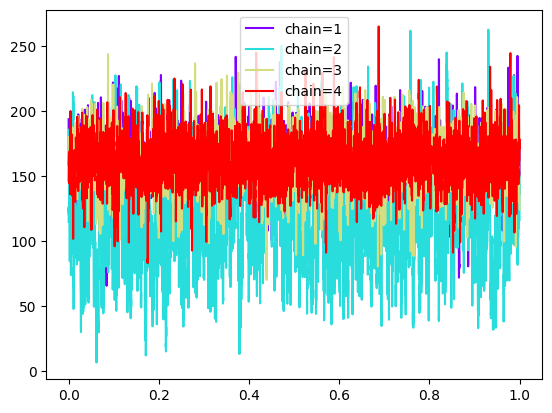

In [ ]:
p, q, r = 1,0,0

color = iter(plt.cm.rainbow(np.linspace(0, 1, 4)))
x = np.linspace(0, 1, 6000)

for i in range(4):
    c = next(color)
    # sns.lineplot(x=x, y=a_base[i, :, p, q, r], color=c, label=f"chain={i+1}")
    sns.lineplot(x=x, y=µ_a[i, :, 0, 0], color=c, label=f"chain={i+1}")

